In [1]:
import numpy as np
from numpy import linalg as la
from matplotlib import pyplot as plt
import qutip as qt

In [3]:
#Functions
def Op_list(N,obs): 
    Op=[]
    I=qt.qeye(2)
    for i in range(N):
        Op_list=[]
        for j in range(N):
            Op_list.append(I)
        Op_list[i] = obs
        Op.append(qt.tensor(Op_list))
    return Op

def all_equal_dm(N):
    dims=int(2**N)
    dm = np.full((dims,dims),1.0/float(dims),dtype=np.complex128)
    return dm  

def J_all2all_het(Js,N):     #All to all random network
    J=np.random.uniform(-Js/2.0,Js/2.0,(N,N))
    return J

def h_het(W,B,N):
    h=0.5*np.random.uniform(B-W,B+W,N) 
    return h

def H_XXZ(J,h,N):
    H=0
    X_=Op_list(N,qt.sigmax())
    Z_=Op_list(N,qt.sigmaz())
    for i in range(N):
        H+=h[i]*Z_[i]
        for j in range(i+1,N):
            H+=J[i,j]*X_[i]*X_[j]
            j+=1
    return H

def ptrace(rho,N):
    reshaped_rho = rho.reshape([2, 2**(N-1), 2, 2**(N-1)])
    reduced_rho = np.einsum('ijik->jk', reshaped_rho,optimize=True) 
    return reduced_rho


def dynamics_no_o(rho_in, s, N, evol_op):
    psi_sk = np.sqrt(1-s) * np.array((1,0),dtype=np.complex128) + np.sqrt(s) * np.array((0,1),dtype=np.complex128)
    rho1 = np.kron(psi_sk,psi_sk.reshape(-1,1))
    reduced_rho = ptrace(rho_in,N)   
    rho_out = np.kron(rho1, reduced_rho)  
    rho_out = np.dot(evol_op, np.dot(rho_out, np.conj(evol_op))) ##evolution
    return rho_out

def dynamics_with_o(rho_in, s, N, evol_op, O):
    psi_sk = np.sqrt(1-s) * np.array((1,0),dtype=np.complex128) + np.sqrt(s) * np.array((0,1),dtype=np.complex128)
    rho1 = np.kron(psi_sk,psi_sk.reshape(-1,1))
    reduced_rho = ptrace(rho_in,N)   
    rho_out = np.kron(rho1, reduced_rho)  
    rho_out = np.dot(evol_op, np.dot(rho_out, np.conj(evol_op))) ##evolution
    o = np.trace(O*rho_out).real #expected value
    return o

In [21]:
#Parameters
N=8 #number of spins
Js=1.0 #coupling strength
hs=10.0 #homogeneous magnetic field
W=0.0 #heterogeneous magnetic field
dt=10.0 #time between inputs
L=1000 #total number of inputs
steps=50 #number of points in the plot

In [22]:
O = Op_list(N,qt.sigmax())[3] #we select the spin projection in the x direction for the spin number 4
s_k = np.random.uniform(0,1,L-1) #input sequence up to L-1
s_L = np.linspace(0,1,steps) #samples of the input axis
obs = np.zeros(steps) #empty array of the observable for the plot
rho = all_equal_dm(N) #initial density matrix
h = h_het(W,hs,N) #array of magnetic fields
J = J_all2all_het(Js,N) #array of couplings
H = H_XXZ(J,h,N) #Hamiltonian
eigvals, eigvects = la.eigh(H) 
P = eigvects.T
evol_op = evol_op = np.dot(P.T, np.dot(np.diag( np.exp(-1j * eigvals * dt) ), P)) #unitary evolution operator
for k in range(0,L-1): #dynamics up to the last input
    rho = dynamics_no_o(rho,s_k[k],N,evol_op)              
for i in range(steps): 
    obs[i] = dynamics_with_o(rho, s_L[i], N, evol_op,O) 

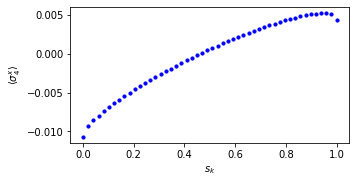

In [23]:
fig, ax = plt.subplots(figsize=(5,2.5))
plt.scatter(s_L,obs,c='b',s=10)
plt.ylabel(r'$\langle\sigma^x_4\rangle $')
plt.xlabel('$s_k$')
plt.show()